In [1]:
using Pkg

In [5]:
Pkg.add("Plots")
Pkg.add("GraphPlot")
Pkg.add("LightGraphs")
Pkg.add("IterTools")
Pkg.add("Roots")

  Resolving package versions...
  Installed FFMPEG_jll ────── v4.3.1+2
  Installed LAME_jll ──────── v3.100.0+2
  Installed LibVPX_jll ────── v1.9.0+0
  Installed Ogg_jll ───────── v1.3.4+1
  Installed libass_jll ────── v0.14.0+3
  Installed Opus_jll ──────── v1.3.1+2
  Installed DataAPI ───────── v1.3.0
  Installed Plots ─────────── v1.6.4
  Installed Zlib_jll ──────── v1.2.11+16
  Installed IniFile ───────── v0.5.0
  Installed EarCut_jll ────── v2.1.5+0
  Installed OpenSSL_jll ───── v1.1.1+5
  Installed Bzip2_jll ─────── v1.0.6+4
  Installed PlotThemes ────── v2.0.0
  Installed FFMPEG ────────── v0.4.0
  Installed Tables ────────── v1.0.5
  Installed GeometryBasics ── v0.3.1
  Installed libvorbis_jll ─── v1.3.6+5
  Installed libfdk_aac_jll ── v0.1.6+3
  Installed FreeType2_jll ─── v2.10.1+4
  Installed FriBidi_jll ───── v1.0.5+5
  Installed Contour ───────── v0.5.5
  Installed GeometryTypes ─── v0.8.3
  Installed HTTP ──────────── v0.8.19
  Installed Adapt ─────────── v2.1.0
  Instal

In [ ]:
Pkg.add("FITSIO")

In [6]:
using Statistics # needed for the mean function

# WQG

In [7]:
include("wqg_wr.jl")
include("wqg_wr-temporary.jl")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Roots [f2b01f46-fcfa-551c-844a-d8ac1e96c665]
└ @ Base loading.jl:1260


plotchain2 (generic function with 1 method)

# parameters

In [8]:
a = 10.0^(0)
b = 1.0
c = 0.6 # caustic constraint parameter
ϵ = 0.0;

### skeleton

3D lattice graph here

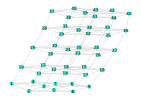

In [9]:
# set skeleton graph
### z1 direction ordinary, the rest directions periodic
z1, z2, z3 = 5,3,3
lgs = [z1,z2,z3]
D = length(lgs)
d = D-1
sk = LightGraphs.SimpleGraphs.grid(lgs[2:D], periodic=true)
sk = cartesian_product(path_graph(z1),sk)

# set interior and boundary edges
levv_all = l_evv_vertices(sk,vertices(sk))
# interior edges:
bn1 = prod(lgs[2:D]) # no. vertices on one boundary
levv_i = l_evv_vertices(sk,bn1+1:bn1*(z1-1))
# boundary edges:
levv_b = setdiff(levv_all,levv_i);

gplot(sk,nodelabel=1:nv(sk))

### initial data

In [31]:
# set boundary configurations:
wv = 10.0^(.5) 
rv = 0.2
wfix = value_hom(sk, D, wv)
rfix = value_hom(sk, D, rv)

# set the variable edges:
levv = levv_all
le = length(levv)
ndim=2*le
#ndim = 2

# set fixed volume
### volume is fixed here
vol = 1000.0
# set initial
wi, wf = 0.01, 50
rst = rv
wst = solve_w_volfix(sk,D,b,levv,wfix,rfix,vol,rst,wi,wf)

# starting configuration
pstart = zeros(ndim)
pstart[1:le] .+= wst
pstart[1+le:end] .+= rst
wstart = set_value(wfix, set_value(sk, levv, pstart[1:le])) 
rstart = set_value(rfix, set_value(sk, levv, pstart[1+le:end]))

burnin=2000
nsteps=100000

#scaling
ws = 1
rs = 1

# proposal jump sizes
jump_r = 1.0/10;

# dstn
jump_r *= 10.

njumps = 2

2

In [32]:
log( camp_VG_wr_measure(sk, D, wstart, rstart, ws, rs, a, ϵ, levv_i, levv_b) ) + ( length(levv_i) * log(d) )

58.03425217562315

### mc run

In [84]:
chain = zeros(nsteps, ndim)
chain_propose_pars = zeros(nsteps, ndim)
chain_logamp = zeros(nsteps)
chain_propose_logamp = zeros(nsteps)
chain_accepted = zeros(Bool, nsteps)
chain_idx_r = zeros(nsteps, njumps)
chain_idx_w = zeros(nsteps, njumps)
chain_propose_r = zeros(nsteps, njumps)
chain_propose_w = zeros(nsteps, njumps)
chain_old_r = zeros(nsteps, njumps)
chain_old_w = zeros(nsteps, njumps)
chain_gap = zeros(nsteps)

# initial parameters
pars = copy(pstart)
naccepted = 0
wvalue = copy(wstart)
rvalue = copy(rstart)

# initial log-posterior.
# logamp = ln_wqg_wr(sk, levv, pars::Vector{Float64}, wfix, rfix, a, b, levv_b)  
logamp = log( camp_VG_wr_measure(sk, D, wvalue, rvalue, ws, rs, a, ϵ, levv_i, levv_b) ) + ( length(levv_i) * log(d) )

## can make more local:
wpropose = set_value(wvalue, set_value(sk, levv, pars[1:le]))
rpropose = set_value(rvalue, set_value(sk, levv, pars[le+1:2*le]))

nok = 0
for step in 1:nsteps
    if (step % 1000 == 0)
        print(step, ' ')
        flush(stdout)
    end
    pars_new = copy(pars)

    # ratio = amp_propose/amp_old
    rn, ro = 1.0, 1.0

    wprev = set_value(wvalue, set_value(sk, levv, pars[1:le]))
    rprev = set_value(wvalue, set_value(sk, levv, pars[le+1:2*le]))

    for jump in 1:njumps
        idx_r = rand(1:le)
        idx_w = idx_r

        chain_idx_w[step, jump] = idx_w
        chain_idx_r[step, jump] = idx_r
        chain_old_r[step, jump] = pars_new[le+idx_r]
        chain_old_r[step, jump] = pars_new[idx_w]

        evv_j = levv[idx_r]
        evv_l = levv[idx_w]
        # apply constraints: 0<w and r<c^2*pi^2
        r_p = pars_new[le+idx_r] + randn() * jump_r
        w_p = w_new(sk, D, evv_j, evv_l, wprev, rprev, r_p)
        if r_p <= c^2 * pi^2 && w_p > 0
            nok += 1
            pars_new[idx_w] = w_p
            pars_new[le+idx_r] = r_p
        end
        chain_propose_r[step, jump] = pars_new[le+idx_r]
        chain_propose_w[step, jump] = pars_new[idx_w]

        # compute log-posterior at new parameters   
        # edges needing update:
        levv_new = union(l_evv_vertices(sk,evv_l.v1),l_evv_vertices(sk,evv_l.v2),[evv_j])
        # proposed w and r configurations:
        ## can make more local:
        wpropose = set_value(wvalue, set_value(sk, levv, pars_new[1:le]))
        rpropose = set_value(rvalue, set_value(sk, levv, pars_new[le+1:2*le]))
    
        for i in levv_new
            α = corners_α_w(sk, D, i, a, wprev)
            α_new = corners_α_w(sk, D, i, a, wpropose)
            if i in levv_i
                campEdge = campEdge_wr_measure(sk, D, wprev, rprev, ws, rs, i, α, ϵ)
                campEdge_new = campEdge_wr_measure(sk, D, wpropose, rpropose, ws, rs, i, α_new, ϵ)
            else 
                campEdge = campEdge_b(sk, D, wprev, rprev, i, α)
                campEdge_new = campEdge_b(sk, D, wpropose, rpropose, i, α_new)
            end
            rn *= campEdge_new
            ro *= campEdge
        end
        
        wprev = wpropose
        rprev = rpropose
    end
    chain_propose_pars[step,:] = pars_new::Vector{Float64}

    # amp_new:
    # The rn and ro value are moderate (> 1e-3, < 1e3)
    logamp_new = logamp + log(rn/ro)
    chain_propose_logamp[step] = logamp_new

    gap = rand(Float64)
    chain_gap[step] = gap
    if exp(logamp_new - logamp) >= gap
        logamp = logamp_new
        pars = pars_new
        naccepted += 1
        wvalue = set_value(wstart, set_value(sk, levv, pars[1:le]))
        rvalue = set_value(rstart, set_value(sk, levv, pars[le+1:2*le]))
        chain_accepted[step] = true
    end
    chain[step,:] = pars::Vector{Float64}
    chain_logamp[step] = logamp
end
# (s,ρ) configurations
chain_sρ = copy(chain)
for i in 1:nsteps
    for j in 1:le
        chain_sρ[i,j] = 1/chain[i,j]
        chain_sρ[i,j+le] = d*chain[i,j]^2*chain[i,j+le]
    end
end

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 

# data display

In [85]:
naccepted, naccepted/nsteps, nok/nsteps/njumps

(23835, 0.23835, 0.978625)

In [86]:
# Save as FITS
using FITSIO
chain_w = zeros(Float32, le, nsteps)
chain_r = zeros(Float32, le, nsteps)
chain_w[:,:] = transpose(chain[:, 1:le])
chain_r[:,:] = transpose(chain[:,le+1:end]);
f = FITS("chain.fits", "w");
data = Dict("chain_w"=>chain_w, "chain_r"=>chain_r);
write(f, data)
close(f)

In [87]:
tstvolume(nsteps)

999.9999999999983

In [145]:
thin = 100

100

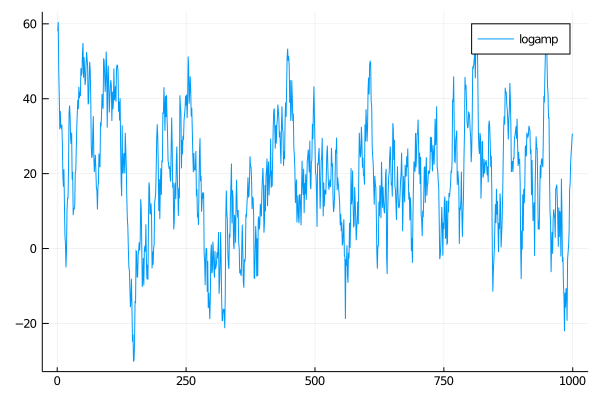

In [146]:
plot(chain_logamp[1:thin:end], label = "logamp")

In [89]:
log( camp_VG_wr_measure(sk, D, wvalue, rvalue, ws, rs, a, ϵ, levv_i, levv_b) ) + ( length(levv_i) * log(d) )

25.67104229453369

In [90]:
chain_logamp[end]

25.671042294533656

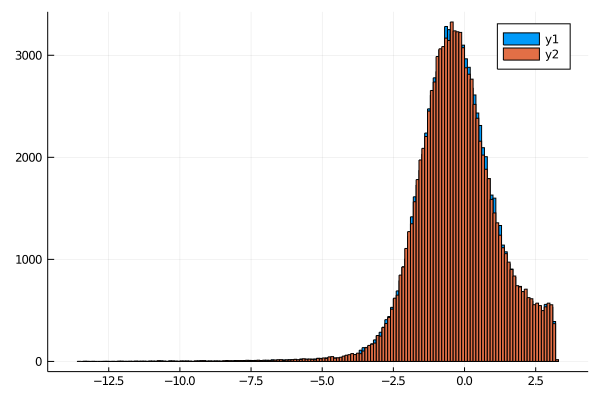

In [92]:
histogram(chain_propose_r - chain_old_r)

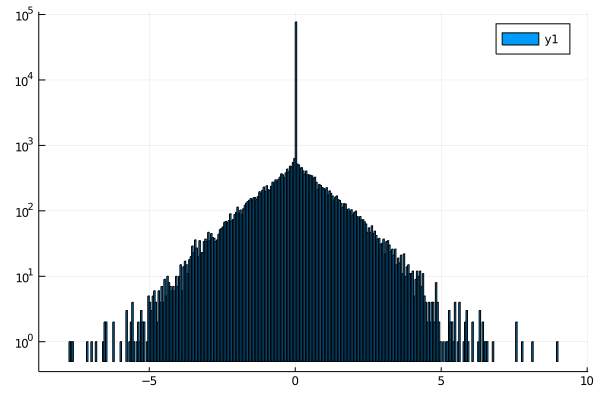

In [93]:
histogram(chain_logamp[2:end] - chain_logamp[1:end-1], yaxis=:log)

In [94]:
accepted = (chain_logamp .== chain_propose_logamp);

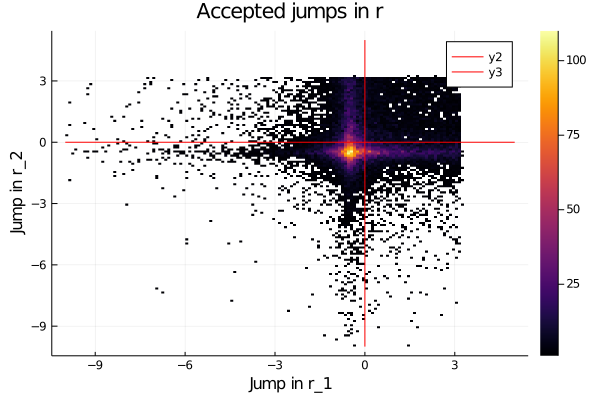

In [123]:
bins = -10:0.1:4
histogram2d(chain_propose_r[accepted, 1] - chain_old_r[accepted, 1],
    chain_propose_r[accepted, 2] - chain_old_r[accepted, 2], bins=bins,
    title="Accepted jumps in r")
xaxis!("Jump in r_1")
yaxis!("Jump in r_2")
plot!([-10,5],[0,0], color="red")
plot!([0,0],[-10,5], color="red")
#savefig("accepted-2.png")

In [124]:
rejected = (chain_logamp .!== chain_propose_logamp);

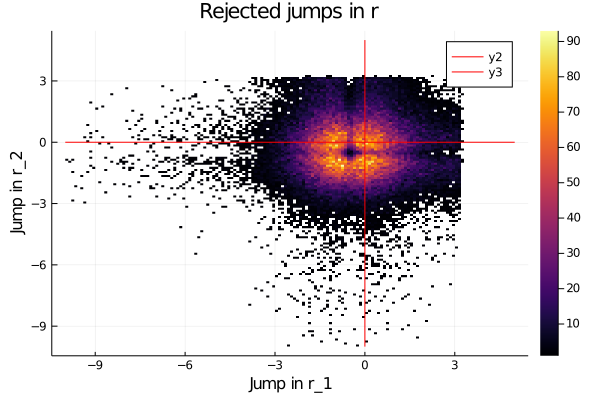

In [126]:
histogram2d(chain_propose_r[rejected, 1] - chain_old_r[rejected, 1],
    chain_propose_r[rejected, 2] - chain_old_r[rejected, 2], bins=bins,
    title="Rejected jumps in r")
xaxis!("Jump in r_1")
yaxis!("Jump in r_2")
plot!([-10,5],[0,0], color="red")
plot!([0,0],[-10,5], color="red")
#savefig("rejected-2.png")

In [ ]:
plot(chain[:,1])
plot!(chain[:,2])
plot!(chain[:,3])
plot!(chain[:,4])
plot!(chain[:,100])

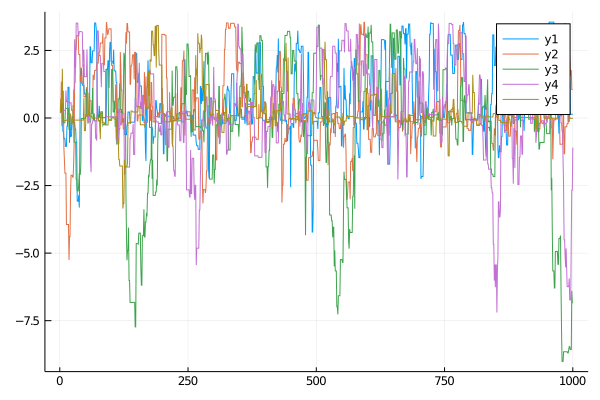

In [98]:
plot(chain[1:thin:end,127])
plot!(chain[1:thin:end,128])
plot!(chain[1:thin:end,129])
plot!(chain[1:thin:end,130])
plot!(chain[1:thin:end,226])

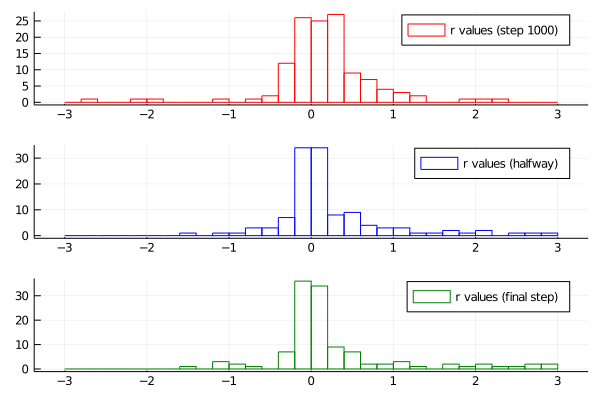

In [144]:
bins=-3:0.2:3
h1 = histogram(vec(chain[1000,         le+1:end]), label="r values (step 1000)",
    bins=bins, fillalpha=0., linecolor="red")
h2 = histogram(vec(chain[Int(nsteps/2),le+1:end]), label="r values (halfway)",
    bins=bins, fillalpha=0., linecolor="blue")
h3 = histogram(vec(chain[nsteps,       le+1:end]), label="r values (final step)",
    bins=bins, fillalpha=0., linecolor="green")
plot(h1,h2,h3, layout=(3,1))
#savefig("r-dist-2.png")

In [129]:
?subplot

search:

Couldn't find subplot
Perhaps you meant split, boxplot, plot, pyplot, gplot or subsets


No documentation found.

Binding `subplot` does not exist.


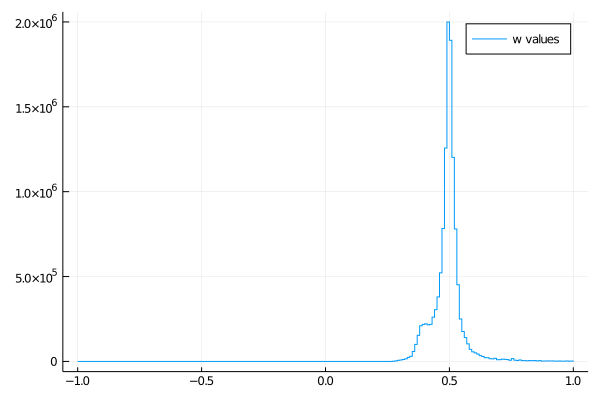

In [148]:
histogram(vec(chain[:,1:126]), label="w values", bins=-1:0.01:1)

In [107]:
Nburn = 1000

1000

In [ ]:
histogram(log.(vec(chain[Nburn:end,1:126])), label="log(w) samples")
#savefig("w-samples-1.png")

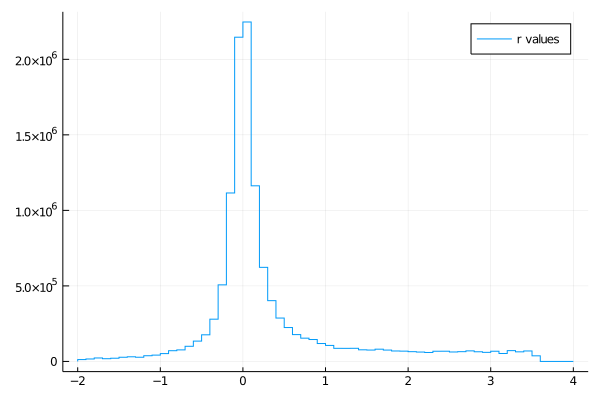

In [149]:
histogram(vec(chain[Nburn:end,127:end]), label="r values", bins=-2:0.1:4)

In [ ]:
histogram(vec(chain[Nburn:end,127:end]), label="r values", bins=range(-3, 5, length=50))
#yaxis!(:log10)

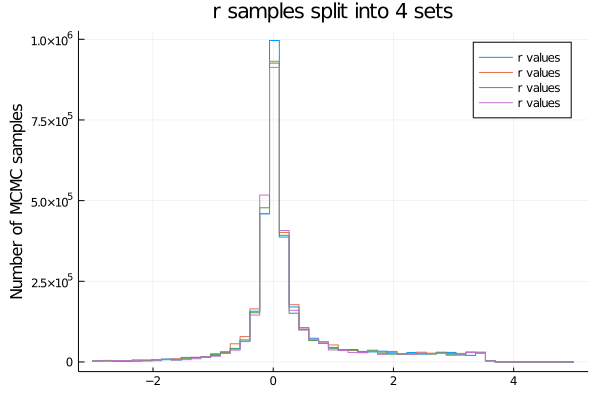

In [109]:
histogram(vec(chain[Nburn:end,127:4:end]), label="r values", bins=range(-3, 5, length=50))
histogram!(vec(chain[Nburn:end,128:4:end]), label="r values", bins=range(-3, 5, length=50))
histogram!(vec(chain[Nburn:end,129:4:end]), label="r values", bins=range(-3, 5, length=50))
histogram!(vec(chain[Nburn:end,130:4:end]), label="r values", bins=range(-3, 5, length=50))
yaxis!("Number of MCMC samples")
title!("r samples split into 4 sets")
#savefig("r-samples-1.png")

In [ ]:
scatter(chain[90000:end,2], chain[90000:end,128]) #, zcolor=chain_logamp[90000:end])
xaxis!("w", :log10)
yaxis!("r")

In [ ]:
mean(wvalue)

In [ ]:
mean(rvalue)

In [ ]:
var(wvalue)

In [ ]:
var(rvalue)

# Search peaks: amplitudes only go up in mcmc

### initial data

In [ ]:
# set boundary configurations:
wv = 10.0^(.5) 
rv = 0.2
wfix = value_hom(sk, D, wv)
rfix = value_hom(sk, D, rv)

# set the variable edges:
levv = levv_all
le = length(levv)
ndim=2*le
#ndim = 2

# set fixed volume
vol = 1000.0
# set initial
wi, wf = 0.01, 50
rst = rv
wst = solve_w_volfix(sk,D,b,levv,wfix,rfix,vol,rst,wi,wf)

# starting configuration
pstart = zeros(ndim)
pstart[1:le] .+= wst
pstart[1+le:end] .+= rst
wstart = set_value(wfix, set_value(sk, levv, pstart[1:le])) 
rstart = set_value(rfix, set_value(sk, levv, pstart[1+le:end]))

burnin=2000
nsteps=5000

#scaling
ws = 1
rs = 1

# proposal jump sizes
jump_w = 1.0/ws
jump_r = 1.0/10;

In [ ]:
log( camp_VG_wr_measure(sk, D, wstart, rstart, ws, rs, a, ϵ, levv_i, levv_b) ) + ( length(levv_i) * log(d) )

In [ ]:
wstart

In [ ]:
rstart

### mc run: chain only increases amplitude

In [ ]:
chain = []
chain_propose_pars = []
chain_logamp = []
chain_propose_logamp = []
chain_idx_r = []
chain_idx_w = []
chain_gap = []

# initial parameters
pars = copy(pstart)
naccepted = 0
wvalue = copy(wstart)
rvalue = copy(rstart)

# initial log-posterior.
#logamp = ln_wqg_wr(sk, levv, pars::Vector{Float64}, wfix, rfix, a, b, levv_b)  
logamp = log( camp_VG_wr_measure(sk, D, wvalue, rvalue, ws, rs, a, ϵ, levv_i, levv_b) ) + ( length(levv_i) * log(d) )

for i in 1:nsteps
    pars_new = copy(pars)
    # generate random edges for moves
    idx_r = rand(1:le)
    idx_w = rand(1:le)
    evv_j = levv[idx_r]
    evv_l = levv[idx_w]
    # apply constraints: 0<w and r<c^2*pi^2
    r_p = pars[le+idx_r] + randn() * jump_r
    w_p = w_new(sk, D, evv_j, evv_l, wvalue, rvalue, r_p)
    if r_p <= c^2 * pi^2 && w_p > 0
        pars_new[idx_w] = w_p
        pars_new[le+idx_r] = r_p
    end
    append!(chain_propose_pars, pars_new::Vector{Float64})
    append!(chain_idx_w, idx_w)
    append!(chain_idx_r, idx_r)
        
    # compute log-posterior at new parameters   
    # edges needing update:
    levv_new = union(l_evv_vertices(sk,evv_l.v1),l_evv_vertices(sk,evv_l.v2),[evv_j])
    # proposed w and r configurations:
    ## can make more local:
    wpropose = set_value(wvalue, set_value(sk, levv, pars_new[1:le]))
    rpropose = set_value(rvalue, set_value(sk, levv, pars_new[le+1:2*le]))
    # ratio = amp_propose/amp_old
    rn, ro = 1.0, 1.0
    for i in levv_new
        α = corners_α_w(sk, D, i, a, wvalue)
        α_new = corners_α_w(sk, D, i, a, wpropose)
        if i in levv_i
            campEdge = campEdge_wr_measure(sk, D, wvalue, rvalue, ws, rs, i, α, ϵ)
            campEdge_new = campEdge_wr_measure(sk, D, wpropose, rpropose, ws, rs, i, α_new, ϵ)
        else 
            campEdge = campEdge_b(sk, D, wvalue, rvalue, i, α)
            campEdge_new = campEdge_b(sk, D, wpropose, rpropose, i, α_new)
        end
        rn *= campEdge_new
        ro *= campEdge
    end
    # amp_new:
    logamp_new = logamp + log(rn/ro)
    append!(chain_propose_logamp, logamp_new)

    gap = rand(Float64)
    append!(chain_gap, gap)
    if exp(logamp_new - logamp) >= 1 ## set chain only increases amplitude
        #(exp(logamp_new - logamp) >= min(1,2*gap) )
        logamp = logamp_new
        pars = pars_new
        naccepted += 1
        wvalue = set_value(wstart, set_value(sk, levv, pars[1:le]))
        rvalue = set_value(rstart, set_value(sk, levv, pars[le+1:2*le]))
    end
    append!(chain, pars::Vector{Float64})
    append!(chain_logamp, logamp)
end
# append! makes "chain" a 1-d vector; reshape to a matrix
chain = reshape(chain, (ndim,Int64(length(chain)/ndim)))';
chain_propose_pars = reshape(chain_propose_pars, (ndim,Int64(length(chain)/ndim)))';
# (s,ρ) configurations
chain_sρ = copy(chain)
for i in 1:nsteps
    for j in 1:le
        chain_sρ[i,j] = 1/chain[i,j]
        chain_sρ[i,j+le] = d*chain[i,j]^2*chain[i,j+le]
    end
end

### data display

In [ ]:
naccepted

In [ ]:
tstvolume(nsteps)

In [ ]:
plot(chain_logamp,1:1:nsteps,label = "logamp")

In [ ]:
chain_logamp

In [ ]:
mean(wvalue)

In [ ]:
mean(rvalue)

In [ ]:
var(wvalue)

In [ ]:
var(rvalue)